# Preprocessing Tabular Data


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

---


In this notebook, we focus on preprocessing tabular data. Then, we use our preprocessed tabular data to select important features and prune unimportant ones out. Finally, we use our selected features to train a machine learning model. We showcase how to preprocess 2 different tabular data sets. 

## Contents
1. [Part 1: Download and Process the Dataset](#Part-1:-Download-and-Process-the-Dataset)
1. [Part 2: Feature Selection for Tabular Data](#Part-2:-Feature-Selection-for-Tabular-Data)
1. [Part 3: Training a Model on Tabular Data using Amazon SageMaker](#Part-3:-Training-a-Model-on-Tabular-Data-using-Amazon-SageMaker)

## Dataset and Package Dependencies

### Tabular Data Sets
* [California House Dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
* [Diabetes Dataset](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html)


### Library Dependencies:
* sagemaker>=2.84.0
* numpy 
* pandas
* plotly
* sklearn 
* matplotlib 
* seaborn


## Setting up the notebook

In [1]:
import os
import sys
import subprocess
import pkg_resources


def get_sagemaker_version():
    "Return the version of 'sagemaker' in your kernel or -1 if 'sagemaker' is not installed"
    for i in pkg_resources.working_set:
        if i.key == "sagemaker":
            return "%s==%s" % (i.key, i.version)
    return -1


# Store original 'sagemaker' version
sagemaker_version = get_sagemaker_version()

# Install any missing dependencies
!{sys.executable} -m pip install -qU 'plotly' 'sagemaker>=2.84.0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import pickle
import ast
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

from sklearn.datasets import *
import sklearn.model_selection
from sklearn.datasets import make_regression
import sklearn.model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

!{sys.executable} -m pip install -qU 'xgboost'
import xgboost
from xgboost import XGBRegressor

# SageMaker dependencies
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve

# This instantiates a SageMaker session that we will be operating in.
session = sagemaker.Session()

# This object represents the IAM role that we are assigned.
role = sagemaker.get_execution_role()
print(role)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwidget 0.20.5 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.1 which is incompatible.
sparkmagic 0.20.5 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
sparkmagic 0.20.5 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.1 which is incompatible.
arn:aws:iam::389338303757:role/LabStack-3eac181e-5fe1-41a4-b1f8-aebd-NotebookRole-7ZAO6DL64PKA


## Part 1: Download and Process the Dataset

This section demonstrates how to preprocess tabular data for training a machine learning model via Amazon SageMaker

### Step 1: Select and Download Data

Here you can select the tabular data set of your choice to preprocess.

In [2]:
data_sets = {"diabetes": "load_diabetes()", "california": "fetch_california_housing()"}

To do select a particular dataset, assign **choosen_data_set** below to be one of 'diabetes', or 'california' where each name corresponds to the it's respective dataset.

* 'california' : [california house data](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
* 'diabetes' : [diabetes data ](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html)

In [3]:
# Change choosen_data_set variable to one of the data sets above.
choosen_data_set = "california"
assert choosen_data_set in data_sets.keys()
print("I selected the '{}' dataset!".format(choosen_data_set))

I selected the 'california' dataset!


### Step 2: Describe Feature Information 

Here you can select the tabular data set of your choice to preprocess.

In [4]:
data_set = eval(data_sets[choosen_data_set])

X = pd.DataFrame(data_set.data, columns=data_set.feature_names)
Y = pd.DataFrame(data_set.target)

print("Features:", list(X.columns))
print("Dataset shape:", X.shape)
print("Dataset Type:", type(X))
print("Label set shape:", Y.shape)
print("Label set Type:", type(X))

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Dataset shape: (20640, 8)
Dataset Type: <class 'pandas.core.frame.DataFrame'>
Label set shape: (20640, 1)
Label set Type: <class 'pandas.core.frame.DataFrame'>


#### We describe both our training data inputs X and outputs Y by computing the count, mean, std, min, percentiles. 

In [5]:
display(X.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [6]:
display(Y.describe())

,0
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


### Step 3: Plot on Feature Correlation
Here we show a heatmap and clustergrid across all our features. These visualizations help us analyze correlated features and are particularly important if we want to remove redundant features. The heatmap computes a similarity score across each feature and colors like features using this score. The clustergrid is similar, however it presents feature correlations hierarchically.

**Note**: For the purposes of this notebook we do not remove any features but by gathering the findings from these plots one may choose to and can do so at this point. 

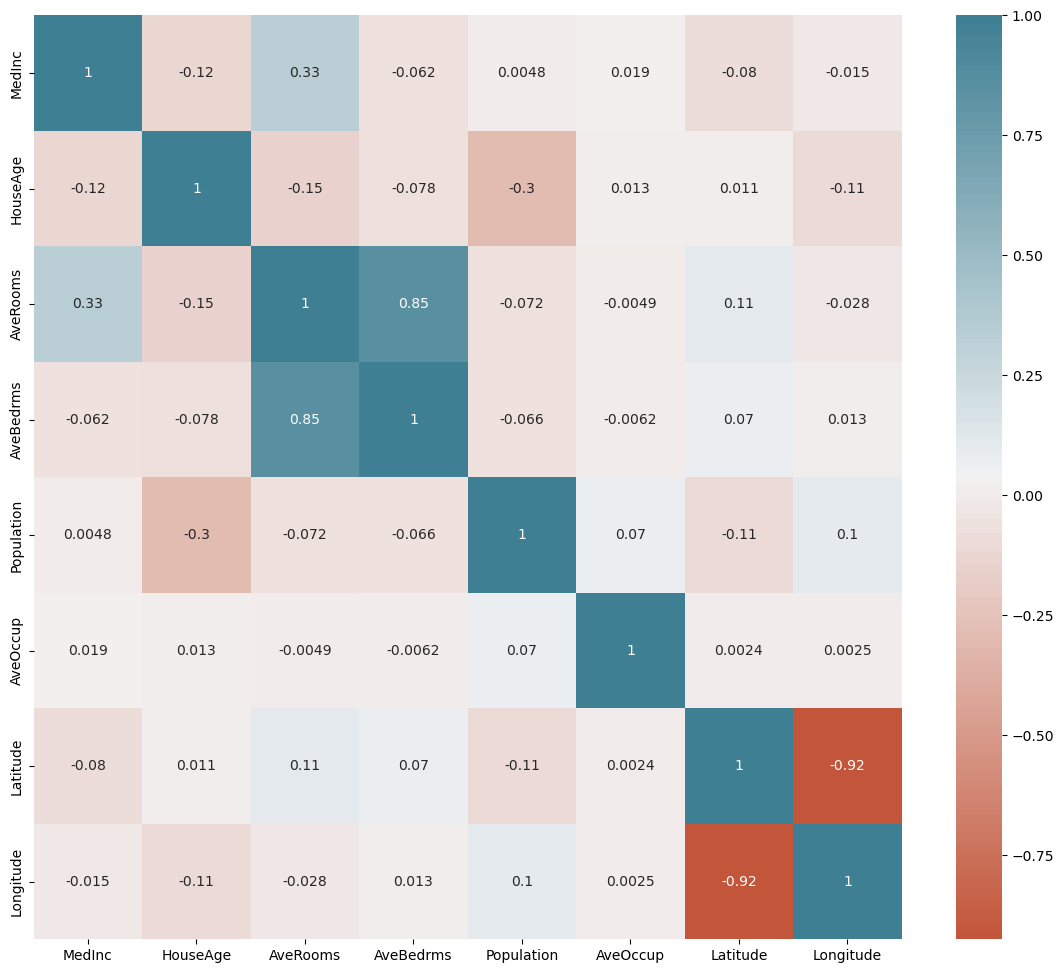

In [7]:
plt.figure(figsize=(14, 12))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

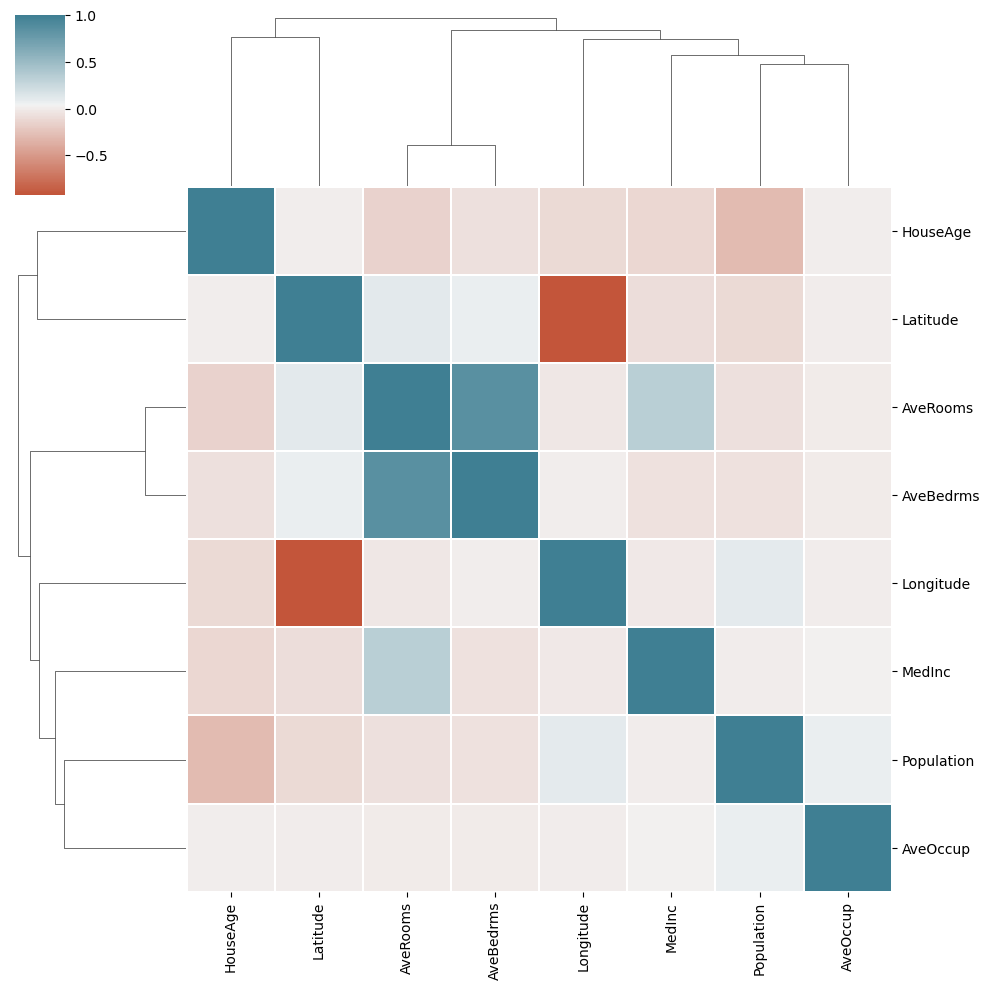

In [8]:
cluster_map = sns.clustermap(cor, cmap=sns.diverging_palette(20, 220, n=200), linewidths=0.1)
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster_map

### Step 4: Partition Dataset into Train, Test, Validation Splits
Here using the sklearn framework we partition our selected dataset into Train, Test and Validation splits. We choose a partition size of 1/3 and then further split the training set into 2/3 training and 1/3 validation set. 

In [9]:
# We partition the dataset into 2/3 training and 1/3 test set.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)

# We further split the training set into a validation set i.e., 2/3 training set, and 1/3 validation set
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.33
)

## Part 2: Feature Selection for Tabular Data

This section demonstrates how to select important features and prune unimportant ones prior to training our machine learning model. This is an important step that yields better prediction performance. 

### Step 1: Computing Feature Importance Scores to Select Features
We show two approaches for computing feature importance scores for each feature. We can rank each feature by their corresponding feature importance score in an effort to prune unimportant features which will yield a better performing model. 

The first approach, uses XGBoost and the second uses permutation feature importance.

### Step 1a: Ranking features by Feature Importance using XGBoost
Here we use gradient boosting to extract importance scores for each feature. The importance scores calculated for each feature inform us how useful the feature was for constructing the boosted decision tree and can be ranked and compared to one another for feature selection.

In [10]:
X_data, y_label = make_regression(
    n_samples=X_train.shape[0], n_features=X_train.shape[1], n_informative=10, random_state=1
)
xgboost_model = XGBRegressor()
xgboost_model.fit(X_data, y_label)

feature_importances_xgboost = xgboost_model.feature_importances_
for index, importance_score in enumerate(feature_importances_xgboost):
    print("Feature: {}, Score: {}".format(X_train.columns[index], importance_score))

Feature: MedInc, Score: 0.15638630092144012
Feature: HouseAge, Score: 0.09933687746524811
Feature: AveRooms, Score: 0.2072921246290207
Feature: AveBedrms, Score: 0.3254247009754181
Feature: Population, Score: 0.003692233469337225
Feature: AveOccup, Score: 0.016900774091482162
Feature: Latitude, Score: 0.02791650965809822
Feature: Longitude, Score: 0.1630505621433258


In [11]:
def create_bar_plot(feature_importances, X_train):
    """
    Create a bar plot of features against their corresponding feature importance score.
    """
    x_indices = [_ for _ in range(len(feature_importances))]
    plt.figure(figsize=(15, 5))
    plt.bar(x_indices, feature_importances, color="blue")
    plt.xticks(x_indices, X_train.columns)
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Importance Score", fontsize=18)
    plt.title("Feature Importance Scores", fontsize=18)
    plt.show()

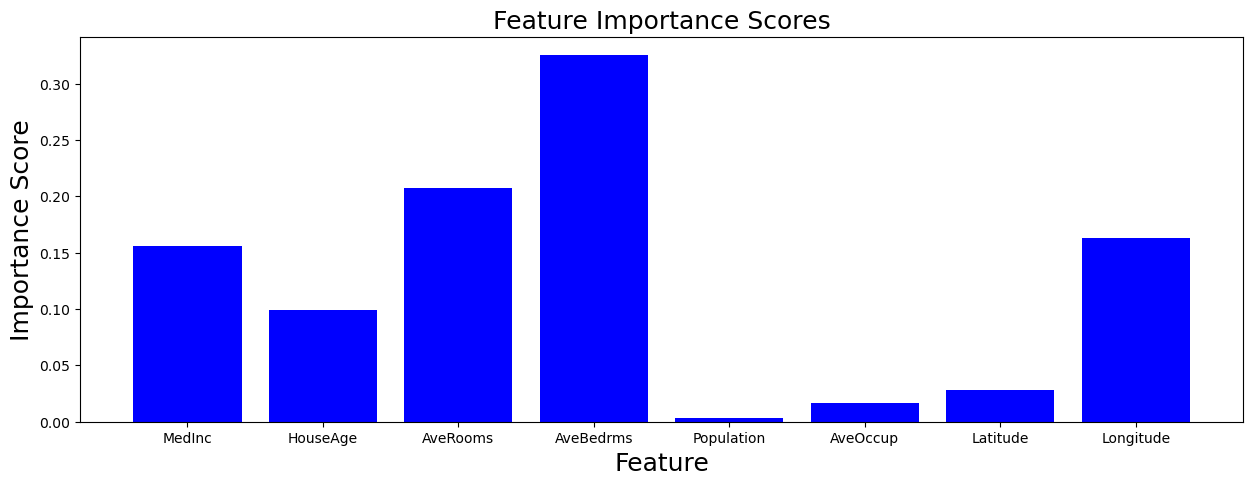

In [12]:
create_bar_plot(feature_importances_xgboost, X_train)

In the following cell, we rank each feature based on corresponding importance score.

In [13]:
def show_ranked_feature_importance_list(scores, data):
    """
    Prints the features ranked by their corresponding importance score.
    """
    lst = list(zip(data.columns, scores))
    ranked_lst = sorted(lst, key=lambda t: t[1], reverse=True)
    print(pd.DataFrame(ranked_lst, columns=["Feature", "Importance Score"]))

In [14]:
show_ranked_feature_importance_list(feature_importances_xgboost, X_train)

      Feature  Importance Score
0   AveBedrms          0.325425
1    AveRooms          0.207292
2   Longitude          0.163051
3      MedInc          0.156386
4    HouseAge          0.099337
5    Latitude          0.027917
6    AveOccup          0.016901
7  Population          0.003692


### Step 1b: Ranking features by Permutation Feature Importance using the Scikit-learn k-NN Algorithm
This approach is commonly used for selecting features in tabular data. We first randomly shuffle a single feature value and train a model. In this example we use the k-nearest-neighbours algorithm to train our model. The permutation feature importance score is the decrease in models score when this single feature value is shuffled. The decrease in the model score is representative of how dependant the model is on the feature. This technique can be computed many times with altering permutations per feature. 

In [15]:
X_data, y_label = make_regression(
    n_samples=X_train.shape[0], n_features=X_train.shape[1], n_informative=10, random_state=1
)
k_nn_model = KNeighborsRegressor()
k_nn_model.fit(X_data, y_label)
feature_importances_permutations = permutation_importance(
    k_nn_model, X_data, y_label, scoring="neg_mean_squared_error"
).importances_mean

for index, importance_score in enumerate(feature_importances_permutations):
    print("Feature: {}, Score: {}".format(X_train.columns[index], importance_score))

Feature: MedInc, Score: 8719.751469835686
Feature: HouseAge, Score: 4785.2227183415725
Feature: AveRooms, Score: 8960.866036248812
Feature: AveBedrms, Score: 14939.934378311857
Feature: Population, Score: 254.14681756720674
Feature: AveOccup, Score: 654.9564660681965
Feature: Latitude, Score: 1094.9561656784624
Feature: Longitude, Score: 6324.624283898505


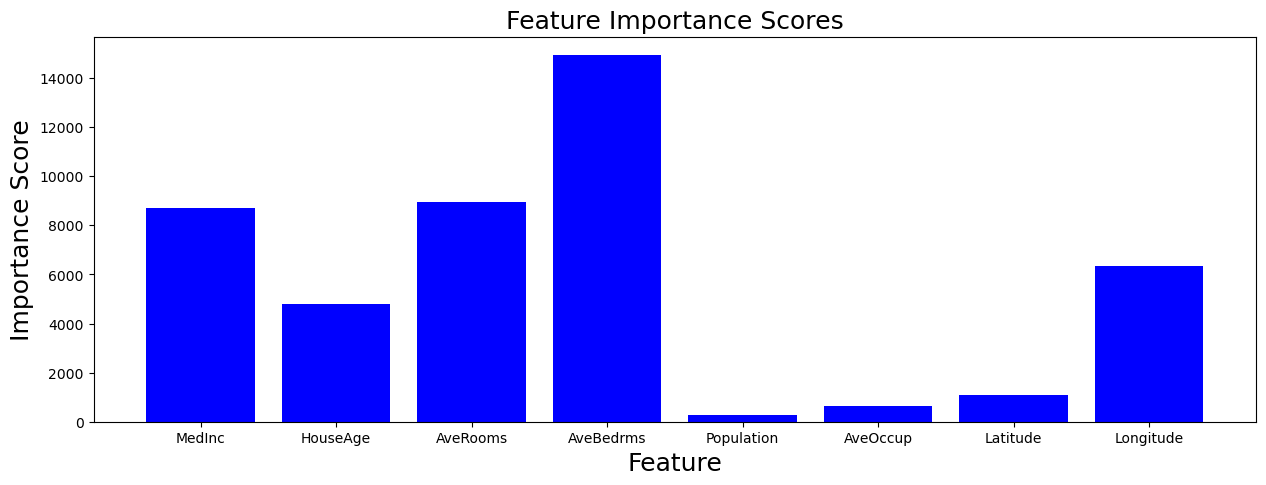

In [16]:
create_bar_plot(feature_importances_permutations, X_train)

In [17]:
show_ranked_feature_importance_list(feature_importances_permutations, X_train)

      Feature  Importance Score
0   AveBedrms      14939.934378
1    AveRooms       8960.866036
2      MedInc       8719.751470
3   Longitude       6324.624284
4    HouseAge       4785.222718
5    Latitude       1094.956166
6    AveOccup        654.956466
7  Population        254.146818


### Step 2: Prune Unimportant Features
Thus far, we have discussed two common approaches for obtaining a ranked list of feature importance scores for each feature. From these lists we can infer unimportant features based on their importance scores and can eliminate them from our training, validation and test sets. For example, if feature A has a higher importance score then feature B's importance score, then this implies that feature A is more important then feature B and vice versa. We mention that both approaches constrain the removal of features to the dataset itself which is independent of the problem domain.

After selecting your desired approach, move onto the next cell to prune features that have the importance score less than or equal to a threshold value. Depending on the approach of your choice and the distribution of scores, the `threshold` value may vary.

In this example, we select the first approach with XGBoost and set the threshold value to 0.01.

In [18]:
threshold = 0.01

In [19]:
def remove_features(lst, data, threshold):
    """
    Remove features found in lst from data iff its importance score is below threshold.
    """
    features_to_remove = []
    for index, pair in enumerate(list(zip(data.columns, lst))):
        if pair[1] <= threshold:
            features_to_remove.append(pair[0])

    if features_to_remove:
        data.drop(features_to_remove, axis=1)

Assign `lst` to be `feature_importances_permutations` or `feature_importances_xgboost` if want to use the ranked list from that uses XGBoost or permutation feature importance respectively.

We remove all features that are below `threshold` from our training data, `X_train`, validation data, `X_val` and testing data `X_test` respectively. 

In [20]:
remove_features(lst=feature_importances_xgboost, data=X_train, threshold=threshold)
remove_features(lst=feature_importances_xgboost, data=X_val, threshold=threshold)
remove_features(lst=feature_importances_xgboost, data=X_test, threshold=threshold)

## Part 3: Training a Model on Tabular Data using Amazon SageMaker

This section demonstrates how to train a machine learning model via Amazon SageMaker using tabular data. You can train either an XGBoost or Linear Learner (regression) model on tabular data in Amazon SageMaker. 


### Step 1: Uploading the data to S3
Here we upload our training and validation data to an S3 bucket. This is a critical step because we will be specifying this S3 bucket's location during the training step. 

In [21]:
data_dir = "../data/" + choosen_data_set
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

prefix = choosen_data_set + "-deploy-hl"
pd.concat([Y_train, X_train], axis=1).to_csv(
    os.path.join(data_dir, "train.csv"), header=False, index=False
)
pd.concat([Y_val, X_val], axis=1).to_csv(
    os.path.join(data_dir, "validation.csv"), header=False, index=False
)

val_location = session.upload_data(os.path.join(data_dir, "validation.csv"), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, "train.csv"), key_prefix=prefix)

Here we have a pointer to our training and validation data sets stored in an S3 bucket. 

In [22]:
s3_input_train = TrainingInput(s3_data=train_location, content_type="text/csv")
s3_input_validation = TrainingInput(s3_data=val_location, content_type="text/csv")

### Step 2: Select and Train the Model
Select between the XGBoost or Linear Learner algorithm by assigning model_selected to either 'xgboost' or 'linear-learner'.

In [23]:
# Select between xgboost or linear-learner (regression)
models = ["xgboost", "linear-learner"]
model_selected = "xgboost"
assert model_selected in models
print("Selected model:", model_selected)

Selected model: xgboost


Here we retrieve our container and instantiate our model object using the Estimator class.

In [24]:
container = retrieve(framework=model_selected, region=session.boto_region_name, version="1.7-1")

model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(session.default_bucket(), prefix),
    sagemaker_session=session,
)

### Step 3: Set hyperparameters
Thus far, we have instantiated our model with our container and uploaded our preprocessed data to our S3 bucket. 
Next, we set our hyperparameters for our choosen model. We note that both [XGBoost](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/xgboost_hyperparameters.html) and [linear learner](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/ll_hyperparameters.html) have different hyperparameters that can be set.

In [25]:
if model_selected == "xgboost":
    model.set_hyperparameters(
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.8,
        objective="reg:linear",
        early_stopping_rounds=10,
        num_round=1,
    )

if model_selected == "linear-learner":
    model.set_hyperparameters(
        feature_dim=X_train.shape[1], predictor_type="regressor", mini_batch_size=100
    )

Our estimator object is instantiated with hyperparameter settings, now it is time to train! To do this we specify our S3 bucket's location that is storing our training data and validation data and pass it via a dictionary to the fit method. 

In [ ]:
model.fit({"train": s3_input_train, "validation": s3_input_validation}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-07-28-21-45-09-549


2023-07-28 21:45:09 Starting - Starting the training job..

### Step 4: Save Trained Model
The model has been trained. Below we select and download the model we just trained above. 

To download the last trained model we assign the `s3_uri` parameter to be `model.model_data`.

In [ ]:
sagemaker.s3.S3Downloader.download(s3_uri=model.model_data, local_path="./")

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/prep_data|tabular_data|train_featurize_train_tabular_data.ipynb)
